<a href="https://colab.research.google.com/github/drawoliver/FitFPData/blob/main/FitFPData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A python jiffy to fit Fluorescence Polarisation data

Antony W. Oliver, University of Sussex (2025)

In [ ]:
#@title Install Packages (Lmfit, Seaborn, Uncertainties)
#Run once initialisation (lmfit, seaborn)
%pip install lmfit
%pip install seaborn
%pip install uncertainties

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.9/98.9 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 5.0 MB/s eta 0:00:00


In [ ]:
#@title Import Required Packages
# Setup requirements
import io
import math
import pandas as pd
import numpy as np
import sympy
import matplotlib.pyplot as plt
import seaborn as sns
import lmfit
import scipy.stats as stats
from matplotlib import rc
from scipy.optimize import curve_fit
from google.colab import files
from google.colab import output
from uncertainties import ufloat

In [ ]:
#@title Upload .csv file

# Upload .csv file and eliminate NaN and column headers
uploaded = files.upload()

# Upload .csv file, drop headers and remove NaN values
filename = next(iter(uploaded))
raw_data = pd.read_csv(filename, header=None, skiprows=0, encoding='utf-8-sig')
raw_data = raw_data.dropna(axis='rows')


data = raw_data

Saving FP.csv to FP (1).csv




Enter 1 to fit a [One Site — Total] model to the data or 2 to fit [Specific Binding with Hill Coefficient]: 1

Either enter the desired maximum Y-axis value (FP) or enter 0 to use the maximum value from input data: 0

Either enter the desired maximum X-axis value (Protein Concentration) or enter 0 to use the maximum value from the input data: 0

Fit converged after 4 iterations.

Fitted Values:

KD: 44.73 µM
95% CI: 43.51 - 45.94 µM

Linear, non-specific component (m): 0.2731
Background, non-specific component (c): 0.04294



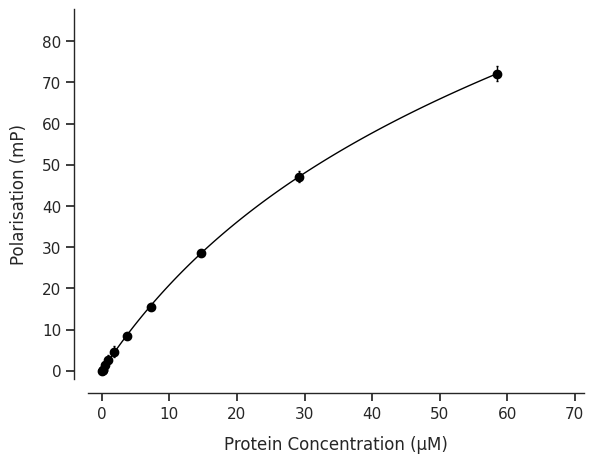

In [ ]:
#@title Process and Fit Data

x_data = data.iloc[:,0]

num_columns = len(data.columns)

for i in range(1, num_columns):
  globals()[f"y_data{i}"] = data.iloc[:,i]
  last_value = globals()[f"y_data{i}"].iloc[-1]  # Store original last value
  globals()[f"y_data{i}"] = globals()[f"y_data{i}"] - last_value  # Subtract the stored value

y_data_df = pd.concat([globals()[f"y_data{i}"] for i in range(1, num_columns)], axis=1)
y_mean = y_data_df.mean(axis=1)
y_std = y_data_df.std(axis=1)

print ()
print ()
choice = input("Enter 1 to fit a [One Site — Total] model to the data or 2 to fit [Specific Binding with Hill Coefficient]: ")
print ()
y_max_input = float(input("Either enter the desired maximum Y-axis value (FP) or enter 0 to use the maximum value from input data: "))
print ()
x_max_input = float(input("Either enter the desired maximum X-axis value (Protein Concentration) or enter 0 to use the maximum value from the input data: "))



# One Site - Total Binding Model
def case1_code():
  def user_defined_equation_1(x, BmaxHi, BmaxLo, KdHi, KdLo, ns, background):
    return (((BmaxHi * x)/ (x + KdHi))+((BmaxLo * x)/(x + KdLo))+(ns * x + background))

  max_iterations = 2000
  initial_guess = [300,0,0,0,0,0]
  bounds_lower = 0
  bounds_upper = 300

  for iteration in range(max_iterations):
    fit_params, covariance = curve_fit(user_defined_equation_1, x_data, y_mean, p0=initial_guess, method='trf', bounds=(bounds_lower, bounds_upper))
    y_fit = user_defined_equation_1(x_data, *fit_params)

    if np.all(np.abs(np.array(initial_guess) - np.array(fit_params)) < 1e-5):
      print()
      print(f'Fit converged after {iteration + 1} iterations.')
      print()
      break

    initial_guess = fit_params

  fit_params_with_errors = []
  for i, param in enumerate(fit_params):
      # Calculate confidence interval using t-distribution
      confidence_interval = stats.t.interval(
          0.95, len(y_mean) - len(fit_params), loc=param, scale=y_std.mean() / np.sqrt(len(y_mean)))
      fit_params_with_errors.append(ufloat(param, (confidence_interval[1] - confidence_interval[0]) / 2))

  KdLo_nominal = fit_params_with_errors[3].nominal_value
  KdLo_upper = KdLo_nominal + 2 * fit_params_with_errors[3].s
  KdLo_lower = KdLo_nominal - 2 * fit_params_with_errors[3].s




  print ("Fitted Values:")
  print ("")
  print (f"KD: {fit_params[3]:.2f} µM")
  print (f"95% CI: {KdLo_lower:.2f} - {KdLo_upper:.2f} µM")
  print ("")
  print (f"Linear, non-specific component (m): {fit_params[4]:.4f}")
  print (f"Background, non-specific component (c): {fit_params[5]:.5f}")
  print ("")

  sns.set_theme(style='white')
  fig, ax = plt.subplots()
  ax.grid(False)
  ax.tick_params(left=True,bottom=True)

  # Plot data with error bars
  ax.errorbar(
      x_data,
      y_mean,
      yerr=y_std,
      fmt="o",
      capsize=1,
      color="black",
      label="Data",
      linewidth=1,
      zorder=5
      )

  if x_max_input == 0:
    x_min, x_max = ax.get_xlim()
    x_ticks = ax.get_xticks()
    x_tick_spacing = np.diff(x_ticks)[0]
    x_max_new = x_max + x_tick_spacing
    ax.set_xlim(-2, x_max_new)

  else:
      x_max_new = x_max_input
      ax.set_xlim(-2, x_max_new)

  if y_max_input == 0:
    y_min, y_max = ax.get_ylim()
    y_ticks = ax.get_yticks()
    y_tick_spacing = np.diff(y_ticks)[0]
    y_max_new = y_max + y_tick_spacing
    ax.set_ylim(-2, y_max_new)

  else:
      y_max_new = y_max_input + 10
      ax.set_ylim(-5, y_max_new)

  ax.spines['bottom'].set_linewidth(1)
  ax.spines['left'].set_linewidth(1)

  ax.spines['top'].set_visible(False)
  ax.spines['right'].set_visible(False)

  ax.spines['left'].set_position(('outward', 10))
  ax.spines['bottom'].set_position(('outward', 10))

  plt.xlabel("Protein Concentration (µM)")
  plt.ylabel("Polarisation (mP)")

  x_fit = np.linspace(min(x_data), max(x_data), 100)  # 100 points for smoothness
  y_fit_smooth = user_defined_equation_1(x_fit, *fit_params)

  y_straight_line = fit_params[4] * x_fit + fit_params[5]

  ax.plot(x_fit, y_fit_smooth, color="black", linewidth=1)

  ax.xaxis.labelpad = 10
  ax.yaxis.labelpad = 10

  plt.show()

# Specific Binding with Hill Coefficient
def case2_code():
  def user_defined_equation_2(x, Bmax, Kd, hill):
    return ((Bmax * (x ** hill))/((Kd ** hill) + (x ** hill)))

  max_iterations = 2000
  initial_guess = [250, 2, 1]
  bounds_lower = 0
  bounds_upper = 300

  for iteration in range(max_iterations):
    fit_params, covariance = curve_fit(user_defined_equation_2, x_data, y_mean, p0=initial_guess, method='trf', bounds=(bounds_lower, bounds_upper))
    y_fit = user_defined_equation_2(x_data, *fit_params)

    # Check for convergence (you can customize this condition based on your needs)
    if np.all(np.abs(np.array(initial_guess) - np.array(fit_params)) < 1e-5):
      print(f'Fit converged after {iteration + 1} iterations.')
      break

    initial_guess = fit_params

  fit_params_with_errors = []
  for i, param in enumerate(fit_params):
      # Calculate confidence interval using t-distribution
      confidence_interval = stats.t.interval(
          0.95, len(y_mean) - len(fit_params), loc=param, scale=y_std.mean() / np.sqrt(len(y_mean))
      )
      fit_params_with_errors.append(ufloat(param, (confidence_interval[1] - confidence_interval[0]) / 2))

  Kd_nominal = fit_params_with_errors[1].nominal_value
  Kd_upper = Kd_nominal + 2 * fit_params_with_errors[1].s
  Kd_lower = Kd_nominal - 2 * fit_params_with_errors[1].s

  print ("Fitted Values:")
  print ("")
  print (f"KD: {fit_params[1]:.2f} µM")
  print (f"95% CI: {Kd_lower:.2f} - {Kd_upper:.2f} µM")
  print ("")
  print (f"Hill Coefficient (h): {fit_params[2]:.2f}")


  sns.set_theme(style='white')
  fig, ax = plt.subplots()
  ax.grid(False)
  ax.tick_params(left=True,bottom=True)

  # Plot data with error bars
  ax.errorbar(
      x_data,
      y_mean,
      yerr=y_std,
      fmt="o",
      capsize=1,
      color="black",
      label="Data",
      linewidth=1,
      zorder=5
      )

  if x_max_input == 0:
    x_min, x_max = ax.get_xlim()
    x_ticks = ax.get_xticks()
    x_tick_spacing = np.diff(x_ticks)[0]
    x_max_new = x_max + x_tick_spacing
    ax.set_xlim(-2, x_max_new)

  else:
      x_max_new = x_max_input
      ax.set_xlim(-2, x_max_new)

  if y_max_input == 0:
    y_min, y_max = ax.get_ylim()
    y_ticks = ax.get_yticks()
    y_tick_spacing = np.diff(y_ticks)[0]
    y_max_new = y_max + y_tick_spacing
    ax.set_ylim(-2, y_max_new)

  else:
      y_max_new = y_max_input + 10
      ax.set_ylim(-5, y_max_new)

  ax.spines['bottom'].set_linewidth(1)
  ax.spines['left'].set_linewidth(1)

  ax.spines['top'].set_visible(False)
  ax.spines['right'].set_visible(False)

  ax.spines['left'].set_position(('outward', 10))
  ax.spines['bottom'].set_position(('outward', 10))

  plt.xlabel("Protein Concentration (µM)")
  plt.ylabel("Polarisation (mP)")

  x_fit = np.linspace(min(x_data), max(x_data), 100)  # 100 points for smoothness
  y_fit_smooth = user_defined_equation_2(x_fit, *fit_params)

  ax.plot(x_fit, y_fit_smooth, color="black", linewidth=1)

  ax.xaxis.labelpad = 10
  ax.yaxis.labelpad = 10

  plt.show()


if choice == "1":
  case1_code()
elif choice == "2":
  case2_code()
else:
  print ("I Give Up ")
